### DCGAN  on MNIST

DCGAN is a Generative Adversarial Network (GAN) using CNN.

1. The discriminator learns to discriminate real from fake images.
2. The generator tries to fool the discriminator by generating fake images.
3. The generator + discriminator form an adversarial network.
4. DCGAN trains the discriminator and adversarial networks alternately.

During training, not only the discriminator learns to distinguish real from
fake images, it also coaches the generator part of the Adversarial network on how
to improve its ability to generate fake images.

In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
import os

#### Buiding a Generator Model

Build a model using layers of BatchNorm-ReLU-Conv2DTranpose to generate fake images

In [2]:
def build_generator(image_size=28, input_size=100):
    
    #Build an input layer
    gen_input = tf.keras.layers.Input(shape=(input_size,))
    
    #Increase dimensions and resize to 3D to feed it to Conv2DTranspose layer
    x = tf.keras.layers.Dense(7 * 7 * 128)(gen_input)
    x = tf.keras.layers.Reshape((7, 7, 128))(x)
    
    #Use ConvTranspose
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(128, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(32, kernel_size=[5,5], strides=1, padding='same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(1, kernel_size=[5,5], strides=1, padding='same')(x)
    
    #Output layer for Generator
    x = tf.keras.layers.Activation('sigmoid')(x)
    
    #Build model using Model API
    generator = tf.keras.models.Model(gen_input, x, name='generator')
    
    return generator

#### Building a Discriminator

In [3]:
def build_discriminator(data_shape=[28,28,1,]):
    
    #Build the network
    dis_input = tf.keras.layers.Input(data_shape)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(dis_input)
    x = tf.keras.layers.Conv2D(32, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(256, kernel_size=[5,5], strides=1, padding='same')(x)
    
    #Flatten the output and build an output layer
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    #Build Model
    discriminator = tf.keras.models.Model(dis_input, x, name='discriminator')
    
    return discriminator

#### Building Models for Training

In [4]:
def build_models():
    
    noise_size = 100
    lr = 2e-4
    decay = 6e-8
    
    #Build Base Discriminator model
    base_discriminator = build_discriminator(data_shape=(28,28,1,))
    
    #Define optimizer and compile model
    discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    optimizer = tf.keras.optimizers.RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    
    #Build Generator model
    generator = build_generator(image_size=28, input_size=noise_size)
    
    #Build Frozen Discriminator
    frozen_discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    #Freeze the weights of discriminator during adversarial training
    frozen_discriminator.trainable = False

    #Build Adversarial model
    optimizer = tf.keras.optimizers.RMSprop(lr=lr * 0.5, decay=decay * 0.5)
    #Adversarial = generator + discriminator
    adversarial = tf.keras.models.Model(generator.input, 
                        frozen_discriminator(generator.output))
    
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])    
    
    return generator, discriminator, adversarial

#### Training Discriminator and Adversarial Models

In [5]:
def train_gan(generator, discriminator, adversarial, noise_size=100):
    
    #Training parameters
    batch_size = 64
    train_steps = 10000
    image_size = 28
    
    # load MNIST dataset
    (train_x, _), (_, _) = tf.keras.datasets.mnist.load_data()
    #Make it 3D dataset
    train_x = np.reshape(train_x, [-1, image_size, image_size, 1])
    #Standardize data : 0 to 1
    train_x = train_x.astype('float32') / 255
    
    #Input for testing generator at different intervals, we will generate 16 images
    test_noise_input = np.random.uniform(-1.0,1.0, size=[16, noise_size])
    
    #Start training
    for i in range(train_steps):
        
        #Train DISCRIMATOR
        
        #1. Get fake images from Generator
        noise_input = np.random.uniform(-1.0,1.0, size=[batch_size, noise_size])
        fake_images = generator.predict(noise_input)
        
        #2. Get real images from training set
        img_indexes = np.random.randint(0, train_x.shape[0], size=batch_size)
        real_images = train_x[img_indexes]
        
        #3. Prepare input for training Discriminator
        X = np.concatenate((real_images, fake_images))
        
        #4. Labels for training
        y_real = np.ones((batch_size, 1))
        y_fake = np.zeros((batch_size, 1))
        y = np.concatenate((y_real, y_fake))
        
        #5. Train Discriminator
        d_loss, d_acc = discriminator.train_on_batch(X, y)
        
        
        #Train ADVERSARIAL Network
        
        #1. Prepare input - create a new batch of noise
        X = noise_input = np.random.uniform(-1.0,1.0, size=[batch_size, noise_size])
        
        #2. Prepare labels - training Adversarial network to lie :) - All 1s
        y = np.ones((batch_size, 1))
        
        #3. Train - Pls note Discrimator is not getting trained here
        a_loss, a_acc = adversarial.train_on_batch(X, y)
        
        if i % 100 == 0:
            #Print loss and Accuracy for both networks
            print("%s [Discriminator loss: %f, acc: %f, Adversarial loss: %f, acc: %f]" % (i, d_loss, d_acc, a_loss, a_acc) )
        
        #Save generated images to see how well Generator is doing
        if (i+1) % 500 == 0:
            
            #Generate 16 images
            fake_images = generator.predict(test_noise_input)
            
            #Display images
            plot_images(fake_images, i+1)
            
    #Save Generator model
    generator.save('mnist_generator_dcgan.h5')    

#### Save generator images

In [6]:
def plot_images(fake_images, step):
    
    plt.figure(figsize=(2.5,2.5))
    num_images = fake_images.shape[0]
    
    image_size = fake_images.shape[1]
    rows = int(math.sqrt(fake_images.shape[0]))
    
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(fake_images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

### Start GAN Training

In [7]:
G, D, A = build_models()

In [8]:
G.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
activation (Activation)      (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       51

In [9]:
D.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         204928

In [10]:
A.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
activation (Activation)      (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512 

11493376/11490434 [==============================] - 0s 0us/step
0 [Discriminator loss: 0.698201, acc: 0.500000, Adversarial loss: 0.791971, acc: 0.000000]
100 [Discriminator loss: 0.000035, acc: 1.000000, Adversarial loss: 0.000038, acc: 1.000000]
200 [Discriminator loss: 0.000071, acc: 1.000000, Adversarial loss: 0.000022, acc: 1.000000]
300 [Discriminator loss: 0.000008, acc: 1.000000, Adversarial loss: 0.000000, acc: 1.000000]
400 [Discriminator loss: 0.140355, acc: 0.976562, Adversarial loss: 3.387811, acc: 0.000000]


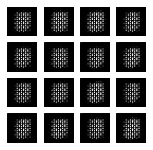

500 [Discriminator loss: 0.253619, acc: 0.992188, Adversarial loss: 5.714032, acc: 0.000000]
600 [Discriminator loss: 0.033020, acc: 0.992188, Adversarial loss: 0.218324, acc: 0.921875]
700 [Discriminator loss: 0.478273, acc: 0.828125, Adversarial loss: 0.445873, acc: 0.765625]
800 [Discriminator loss: 0.418174, acc: 0.804688, Adversarial loss: 2.297605, acc: 0.015625]
900 [Discriminator loss: 0.543186, acc: 0.750000, Adversarial loss: 0.541862, acc: 0.765625]


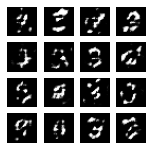

1000 [Discriminator loss: 0.494984, acc: 0.773438, Adversarial loss: 0.776744, acc: 0.453125]
1100 [Discriminator loss: 0.522700, acc: 0.757812, Adversarial loss: 0.771412, acc: 0.406250]
1200 [Discriminator loss: 0.470799, acc: 0.765625, Adversarial loss: 0.766928, acc: 0.500000]
1300 [Discriminator loss: 0.503386, acc: 0.718750, Adversarial loss: 0.830590, acc: 0.421875]
1400 [Discriminator loss: 0.669224, acc: 0.695312, Adversarial loss: 0.688863, acc: 0.578125]


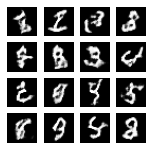

1500 [Discriminator loss: 0.525901, acc: 0.718750, Adversarial loss: 2.280092, acc: 0.015625]
1600 [Discriminator loss: 0.409243, acc: 0.835938, Adversarial loss: 1.478372, acc: 0.078125]
1700 [Discriminator loss: 0.489817, acc: 0.734375, Adversarial loss: 1.196832, acc: 0.171875]
1800 [Discriminator loss: 0.601582, acc: 0.632812, Adversarial loss: 1.566490, acc: 0.062500]
1900 [Discriminator loss: 0.548681, acc: 0.718750, Adversarial loss: 0.841571, acc: 0.593750]


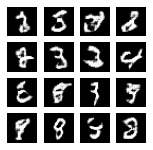

2000 [Discriminator loss: 0.569990, acc: 0.703125, Adversarial loss: 0.868377, acc: 0.343750]
2100 [Discriminator loss: 0.469606, acc: 0.781250, Adversarial loss: 0.769025, acc: 0.546875]
2200 [Discriminator loss: 0.468832, acc: 0.812500, Adversarial loss: 1.317219, acc: 0.187500]
2300 [Discriminator loss: 0.487201, acc: 0.781250, Adversarial loss: 1.378457, acc: 0.187500]
2400 [Discriminator loss: 0.632806, acc: 0.695312, Adversarial loss: 0.893434, acc: 0.359375]


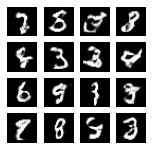

2500 [Discriminator loss: 0.627722, acc: 0.687500, Adversarial loss: 0.943193, acc: 0.375000]
2600 [Discriminator loss: 0.544406, acc: 0.710938, Adversarial loss: 1.698217, acc: 0.078125]
2700 [Discriminator loss: 0.505810, acc: 0.718750, Adversarial loss: 1.734838, acc: 0.125000]
2800 [Discriminator loss: 0.522337, acc: 0.742188, Adversarial loss: 1.129436, acc: 0.375000]
2900 [Discriminator loss: 0.537225, acc: 0.734375, Adversarial loss: 1.583937, acc: 0.140625]


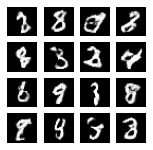

3000 [Discriminator loss: 0.539098, acc: 0.742188, Adversarial loss: 1.274743, acc: 0.171875]
3100 [Discriminator loss: 0.440639, acc: 0.765625, Adversarial loss: 1.052847, acc: 0.328125]
3200 [Discriminator loss: 0.475513, acc: 0.796875, Adversarial loss: 1.637038, acc: 0.171875]
3300 [Discriminator loss: 0.522504, acc: 0.757812, Adversarial loss: 1.765036, acc: 0.078125]
3400 [Discriminator loss: 0.517393, acc: 0.765625, Adversarial loss: 1.315418, acc: 0.203125]


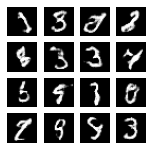

3500 [Discriminator loss: 0.581421, acc: 0.718750, Adversarial loss: 1.617802, acc: 0.125000]
3600 [Discriminator loss: 0.591945, acc: 0.710938, Adversarial loss: 1.023596, acc: 0.343750]
3700 [Discriminator loss: 0.515260, acc: 0.757812, Adversarial loss: 1.533547, acc: 0.156250]
3800 [Discriminator loss: 0.503896, acc: 0.757812, Adversarial loss: 1.186329, acc: 0.265625]
3900 [Discriminator loss: 0.557620, acc: 0.710938, Adversarial loss: 1.001376, acc: 0.312500]


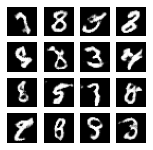

4000 [Discriminator loss: 0.524178, acc: 0.734375, Adversarial loss: 0.862439, acc: 0.500000]
4100 [Discriminator loss: 0.490086, acc: 0.734375, Adversarial loss: 1.108758, acc: 0.312500]
4200 [Discriminator loss: 0.560480, acc: 0.734375, Adversarial loss: 0.961379, acc: 0.359375]
4300 [Discriminator loss: 0.547492, acc: 0.718750, Adversarial loss: 1.661118, acc: 0.125000]
4400 [Discriminator loss: 0.482797, acc: 0.734375, Adversarial loss: 1.485397, acc: 0.109375]


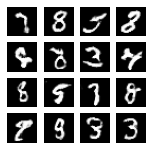

4500 [Discriminator loss: 0.528696, acc: 0.703125, Adversarial loss: 1.049649, acc: 0.296875]
4600 [Discriminator loss: 0.491342, acc: 0.796875, Adversarial loss: 1.030337, acc: 0.390625]
4700 [Discriminator loss: 0.621728, acc: 0.679688, Adversarial loss: 0.951114, acc: 0.359375]
4800 [Discriminator loss: 0.552930, acc: 0.664062, Adversarial loss: 1.128230, acc: 0.218750]
4900 [Discriminator loss: 0.567700, acc: 0.710938, Adversarial loss: 1.240974, acc: 0.265625]


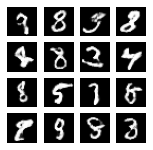

5000 [Discriminator loss: 0.541536, acc: 0.773438, Adversarial loss: 1.264878, acc: 0.218750]


In [ ]:
train_gan(G, D, A)